In [1]:
# %%
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import requests
import json
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from stats import *
import shap

c:\Users\limaga\AppData\Local\miniforge3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %%
# Charge les données des actions à partir d'un fichier JSON
with open('./stock_data.json', 'r') as file:
    data_stock = json.load(file)

# Charge les données des options à partir d'un fichier JSON
with open('./options_data.json', 'r') as file:
    data_opt = json.load(file)

# Convertit les données des actions en un DataFrame pandas
df_stock = pd.DataFrame.from_dict(data_stock['Time Series (Daily)'], orient='index')

# Convertit les données des options en un DataFrame pandas
df_opt = pd.DataFrame.from_dict(data_opt['data'])

# %%
# Réinitialise l'index du DataFrame df_stock et le transforme en colonne
df_stock.reset_index(inplace=True)

# Définit les noms des colonnes de df_stock
df_stock.columns = ['Date','Open','High','Low','Close','Volume_stock']

# Convertit les noms des colonnes de df_opt pour qu'ils commencent par une majuscule
df_opt.columns = df_opt.columns.map(lambda x: x.capitalize())

# Renomme la colonne 'Volume' en 'Volume_option'
df_opt.rename(columns={'Volume':'Volume_option'}, inplace = True)

# Fusionne les DataFrames df_stock et df_opt en se basant sur la colonne 'Date'
df_aapl = df_stock.merge(df_opt, on='Date', how='inner')

In [3]:
# %%
important_cols = [
 'Bid_size',
 'Ask_size',
 'Implied_volatility',
 'Theta',
 'Rho']

# %%
# Liste des colonnes numériques à convertir en type float
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume_stock',
              'Strike', 'Last', 'Mark', 'Bid',
              'Bid_size', 'Ask', 'Ask_size', 'Volume_option', 'Open_interest',
              'Implied_volatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']

# Convertit les colonnes numériques sélectionnées en type float
df_aapl[numeric_cols] = df_aapl[numeric_cols].astype(float)

# Aplicar a função no DataFrame df_aapl e na coluna 'Implied_volatility'
col = 'Implied_volatility'
df_norm = normalize_columns(df_aapl, important_cols)
outliers, not_outliers = boxcox_outliers(df_norm, col)

Utilisation de Box-Cox pour la colonne Bid_size
Utilisation de Box-Cox pour la colonne Ask_size
Utilisation de Box-Cox pour la colonne Implied_volatility
Utilisation de Yeo-Johnson pour la colonne Theta
Utilisation de Yeo-Johnson pour la colonne Rho


In [6]:
# Suponha que df_aapl é seu DataFrame com as features
X = df_norm[important_cols]

# Criar e treinar o modelo
model = IsolationForest(contamination='auto')  # Ajuste a contaminação conforme necessário
model.fit(X)

# Predizer anomalias
df_norm['Anomaly'] = model.predict(X)

# -1 indica anomalias, 1 indica dados normais
outliers = df_norm[df_norm['Anomaly'] == -1].drop(columns='Anomaly')

In [11]:
# Suponha que você tenha um modelo treinado (por exemplo, Isolation Forest)
explainer = shap.TreeExplainer(model)  # Para modelos baseados em árvore
shap_values = explainer.shap_values(outliers[important_cols])

In [16]:
# Criar um DataFrame para facilitar a análise
shap_columns = [f'Shap_{col}' for col in important_cols]
shap_df = pd.DataFrame(data=shap_values, columns=shap_columns)

In [31]:
shap_df.columns

Index(['Shap_Bid_size', 'Shap_Ask_size', 'Shap_Implied_volatility',
       'Shap_Theta', 'Shap_Rho'],
      dtype='object')

In [38]:
df = pd.concat([outliers.reset_index(drop=True),shap_df.reset_index(drop=True)], axis=1)

In [40]:
df

,Date,Open,High,Low,Close,Volume_stock,Contractid,Symbol,Expiration,Strike,...,Delta,Gamma,Theta,Vega,Rho,Shap_Bid_size,Shap_Ask_size,Shap_Implied_volatility,Shap_Theta,Shap_Rho
0,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011C00100000,AAPL,2024-10-11,100.0,...,0.99517,0.00018,-2.217218,0.00238,-0.104737,0.201289,0.460524,-2.602608,-1.580535,0.372609
1,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011P00100000,AAPL,2024-10-11,100.0,...,-0.00057,0.00003,-0.568013,0.00034,-0.109948,-0.667639,-2.712453,-1.824898,-0.263127,0.338897
2,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011C00105000,AAPL,2024-10-11,105.0,...,0.99493,0.00020,-2.216422,0.00249,-0.104477,0.264682,0.327241,-2.629309,-1.577632,0.371429
3,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011P00105000,AAPL,2024-10-11,105.0,...,-0.00061,0.00004,-0.562852,0.00036,-0.109948,-0.735134,-0.528237,-2.185813,-0.357741,0.390194
4,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011C00110000,AAPL,2024-10-11,110.0,...,0.99468,0.00022,-2.215580,0.00260,-0.104217,0.166740,0.419256,-2.561951,-1.613193,0.363177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL270115P00420000,AAPL,2027-01-15,420.0,...,-0.55136,0.00197,0.868193,1.36779,-4.298130,0.259411,0.345292,-0.109277,0.155548,-3.529169
379,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL270115P00430000,AAPL,2027-01-15,430.0,...,-0.54980,0.00192,0.851145,1.36847,-4.393234,0.241486,0.304418,-0.174886,0.183011,-3.622976
380,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL270115P00440000,AAPL,2027-01-15,440.0,...,-0.54791,0.00186,0.834203,1.36927,-4.486920,0.250164,0.285152,-0.234402,0.177519,-3.599594
381,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL270115C00450000,AAPL,2027-01-15,450.0,...,0.06458,0.00164,0.742996,0.43613,0.185930,-1.177835,-1.448301,0.214869,0.048032,0.137835


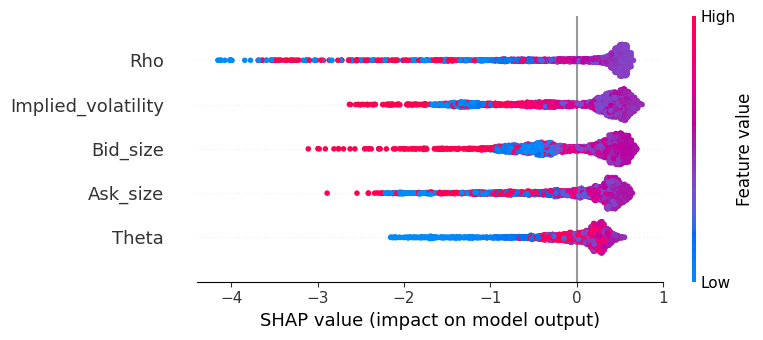

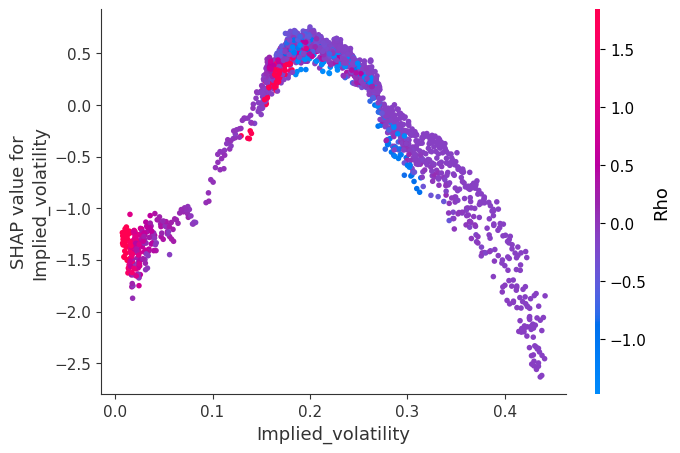

In [37]:
# Resumo dos valores SHAP
shap.summary_plot(shap_values, X)

# Gráfico de dependência para uma feature específica
shap.dependence_plot(col, shap_values.values, X)


In [25]:
print(shap_values)

[[ 0.32069821  0.38545185 -2.07082924 -1.94365858  0.38634571  0.        ]
 [-0.82115787 -1.87860768 -1.597181   -0.26443221  0.42099021  0.        ]
 [ 0.44200862  0.33018513 -1.92166392 -1.94625249  0.3993476   0.        ]
 ...
 [ 0.21593788  0.15575747 -0.24685668  0.21210783 -3.69065828  0.        ]
 [-0.7474461  -1.79767821  0.29137502  0.31219735  0.30586005  0.        ]
 [ 0.19489429  0.17716617 -0.26649325  0.20966207 -3.71795846  0.        ]]


In [29]:
outliers

,Date,Open,High,Low,Close,Volume_stock,Contractid,Symbol,Expiration,Strike,...,Open_interest,Implied_volatility,Delta,Gamma,Theta,Vega,Rho,boxcox_Implied_volatility,anomaly,Anomaly
0,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011C00100000,AAPL,2024-10-11,100.0,...,1.0,4.64792,0.99517,0.00018,-1.05789,0.00238,0.00541,0.435377,-1,-1
1,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011P00100000,AAPL,2024-10-11,100.0,...,9.0,3.60023,-0.00057,0.00003,-0.11243,0.00034,-0.00001,0.430076,-1,1
5,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011P00110000,AAPL,2024-10-11,110.0,...,1.0,3.20634,-0.00064,0.00004,-0.11141,0.00038,-0.00001,0.426877,-1,1
7,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011P00115000,AAPL,2024-10-11,115.0,...,0.0,3.02235,-0.00068,0.00005,-0.11081,0.00040,-0.00001,0.425020,-1,1
12,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011C00130000,AAPL,2024-10-11,130.0,...,0.0,3.25177,0.99349,0.00033,-0.98297,0.00310,0.00703,0.427296,-1,-1
20,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011C00150000,AAPL,2024-10-11,150.0,...,448.0,2.18944,0.99661,0.00027,-0.41848,0.00173,0.00817,0.411727,-1,1
28,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011C00170000,AAPL,2024-10-11,170.0,...,111.0,1.90530,0.98615,0.00109,-1.12503,0.00601,0.00913,0.404091,-1,1
34,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011C00185000,AAPL,2024-10-11,185.0,...,348.0,1.42361,0.98224,0.00181,-1.05347,0.00744,0.00990,0.383783,-1,1
36,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011C00190000,AAPL,2024-10-11,190.0,...,259.0,1.19968,0.98523,0.00183,-0.78509,0.00635,0.01022,0.369003,-1,1
40,2024-10-09,225.23,229.75,224.83,229.54,33591091.0,AAPL241011C00195000,AAPL,2024-10-11,195.0,...,167.0,1.05365,0.98355,0.00229,-0.76195,0.00697,0.01047,0.356398,-1,1


In [ ]:
from sklearn.cluster import DBSCAN

# Ajuste os parâmetros de eps e min_samples conforme necessário
db = DBSCAN(eps=0.5, min_samples=5).fit(X)

# Adiciona a coluna de rótulos
df_aapl['anomaly'] = db.labels_

# Identificar anomalias (-1 indica anomalias)
outliers = df_aapl[df_aapl['anomaly'] == -1]

In [16]:
from sklearn.svm import OneClassSVM

# Criar e treinar o modelo
model = OneClassSVM(gamma='auto', nu=0.05)  # Ajuste nu conforme necessário
model.fit(X)

# Predizer anomalias
df_aapl['anomaly'] = model.predict(X)

# Identificar anomalias (-1 indica anomalias)
outliers = df_aapl[df_aapl['anomaly'] == -1]
print(outliers)


            Date    Open    High     Low   Close  Volume_stock  \
0     2024-10-09  225.23  229.75  224.83  229.54    33591091.0   
1     2024-10-09  225.23  229.75  224.83  229.54    33591091.0   
5     2024-10-09  225.23  229.75  224.83  229.54    33591091.0   
7     2024-10-09  225.23  229.75  224.83  229.54    33591091.0   
9     2024-10-09  225.23  229.75  224.83  229.54    33591091.0   
...          ...     ...     ...     ...     ...           ...   
2328  2024-10-09  225.23  229.75  224.83  229.54    33591091.0   
2332  2024-10-09  225.23  229.75  224.83  229.54    33591091.0   
2342  2024-10-09  225.23  229.75  224.83  229.54    33591091.0   
2344  2024-10-09  225.23  229.75  224.83  229.54    33591091.0   
2345  2024-10-09  225.23  229.75  224.83  229.54    33591091.0   

               Contractid Symbol  Expiration  Strike  ... Volume_option  \
0     AAPL241011C00100000   AAPL  2024-10-11   100.0  ...           0.0   
1     AAPL241011P00100000   AAPL  2024-10-11   100.0  ...

In [20]:
outliers.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume_stock', 'Contractid',
       'Symbol', 'Expiration', 'Strike', 'Type', 'Last', 'Mark', 'Bid',
       'Bid_size', 'Ask', 'Ask_size', 'Volume_option', 'Open_interest',
       'Implied_volatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho',
       'boxcox_Implied_volatility', 'anomaly'],
      dtype='object')

<Axes: >

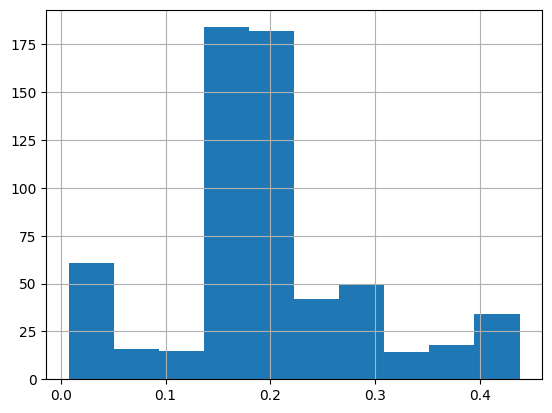

In [21]:
outliers.boxcox_Implied_volatility.hist()

In [17]:
outliers[outliers.anomaly != -1]

,Date,Open,High,Low,Close,Volume_stock,Contractid,Symbol,Expiration,Strike,...,Volume_option,Open_interest,Implied_volatility,Delta,Gamma,Theta,Vega,Rho,boxcox_Implied_volatility,anomaly


In [ ]:
# Prever a volatilidade implícita para o contrato específico
X = df_aapl[important_cols].drop(columns=['Implied_volatility'])
y = df_aapl['Implied_volatility']

# %%
# Filtrar o contrato específico
contract_id = 'AAPL241011C00100000'  # Substitua pelo ID do contrato que você está analisando
contract_data = df_aapl[df_aapl['Contractid'] == contract_id]

# Prever a volatilidade implícita para o contrato específico
X_contract = contract_data[important_cols].drop(columns=['Implied_volatility'])
y_contract = contract_data['Implied_volatility']

# %%
# Calcular a média e o desvio padrão históricos para cada feature
mean_features = X.mean()
std_features = X.std()

# Calcular quantos desvios padrões o valor do contrato específico está da média histórica
z_scores = (X_contract.values[0] - mean_features) / std_features

# Criar um DataFrame para mostrar as distâncias em desvios padrões
z_scores_df = pd.DataFrame({'Z-Score': z_scores, 'Mean': mean_features, 'Observed Value': X_contract.iloc[0]})
z_scores_df['Absolute Z-Score'] = z_scores_df['Z-Score'].abs()

z_scores_df = z_scores_df.sort_values(by='Absolute Z-Score', ascending=False)

# %%
explanation(z_scores_df, contract_id)